# Imports

In [ ]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
from datetime import datetime, timedelta
from functools import partial
from enum import Enum
from typing import Callable, List
import itertools
from tqdm import tqdm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load historical data

In [ ]:
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
price_history_df = pd.read_csv(io.BytesIO(uploaded['BTC-USD.csv']))

In [ ]:
price_history_df.head()

Date  Year       Price
0  2014-09-17  2014  465.864014
1  2014-09-18  2014  456.859985
2  2014-09-19  2014  424.102997
3  2014-09-20  2014  394.673004
4  2014-09-21  2014  408.084991

# Pre-process


## Rolling returns

In [ ]:
class TimeWindow:

  time_units_meta = {
      "months": {
          "singular": "month",
          "plural": "months",
          "days_contained": 30
      },
      "years": {
          "singular": "year",
          "plural": "years",
          "days_contained": 365
      }
  }

  def __init__(self, time_unit: str, length: int):
    if time_unit not in self.time_units_meta:
      raise ValueError(f"Invalid time unit: {time_unit}")
    self.unit = time_unit
    self.length = length

  @property
  def days(self):
    return self.length * self.time_units_meta[self.unit]["days_contained"]

  @property
  def unit_name(self):
    if self.length > 1:
      return self.time_units_meta[self.unit]["plural"]
    return self.time_units_meta[self.unit]["singular"]

  @property
  def years(self):
    return self.days / 365

In [ ]:
def add_rolling_returns(
    price_history_df: pd.DataFrame, 
    window: TimeWindow
    ) -> pd.DataFrame:
  price_history_df[f"price_{window.length}_{window.unit_name}_ago"] = price_history_df.shift(window.days)["Price"]
  price_history_df[f"returns_for_{window.length}_{window.unit_name}"] = (
      (price_history_df["Price"] - price_history_df[f"price_{window.length}_{window.unit_name}_ago"]) / price_history_df[f"price_{window.length}_{window.unit_name}_ago"]
  )
  price_history_df[f"annualized_returns_for_{window.length}_{window.unit_name}"] = ((price_history_df[f"returns_for_{window.length}_{window.unit_name}"] + 1)**(1/window.years))-1
  return price_history_df


In [ ]:
windows_to_use = [TimeWindow("months", i) for i in range(1, 2)] # + [TimeWindow("years", i) for i in range(1, 5)]

for window in windows_to_use:
  price_history_df = add_rolling_returns(price_history_df, window=window)

In [ ]:
price_history_df

Date  Year     Price  price_1_month_ago  returns_for_1_month  \
0     2014-09-17  2014   465.864                NaN                  NaN   
1     2014-09-18  2014   456.860                NaN                  NaN   
2     2014-09-19  2014   424.103                NaN                  NaN   
3     2014-09-20  2014   394.673                NaN                  NaN   
4     2014-09-21  2014   408.085                NaN                  NaN   
...          ...   ...       ...                ...                  ...   
2754  2022-04-02  2022 46285.500          43925.195                0.054   
2755  2022-04-03  2022 45859.129          42458.141                0.080   
2756  2022-04-04  2022 46445.273          39148.449                0.186   
2757  2022-04-05  2022 46624.508          39404.199                0.183   
2758  2022-04-06  2022 45491.375          38429.305                0.184   

      annualized_returns_for_1_month  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
...                              ...  
2754                           0.890  
2755                           1.554  
2756                           7.000  
2757                           6.745  
2758                           6.788  

[2759 rows x 6 columns]

# Data Exploration


## Distributions of total returns

In [ ]:
for window_years in window_years_to_use:
  print(price_history_df[f"returns_for_{window_years}_years"].describe())

count    2394.000000
mean        2.163473
std         3.208595
min        -0.832966
25%         0.282227
50%         1.160037
75%         2.831518
max        23.804691
Name: returns_for_1_years, dtype: float64
count    2029.000000
mean        6.618032
std         7.548360
min        -0.652070
25%         1.313161
50%         3.552320
75%         9.278709
max        41.956416
Name: returns_for_2_years, dtype: float64
count    1664.000000
mean       13.073746
std        11.922938
min        -0.002926
25%         4.844270
50%         8.870996
75%        16.546371
max        80.238232
Name: returns_for_3_years, dtype: float64
count    1299.000000
mean       20.246075
std        12.466027
min         1.417540
25%        12.310428
50%        16.681005
75%        25.459926
max        59.296171
Name: returns_for_4_years, dtype: float64
count    934.000000
mean      55.868363
std       31.396123
min       16.830084
25%       33.854491
50%       44.534378
75%       74.665779
max      148.669445


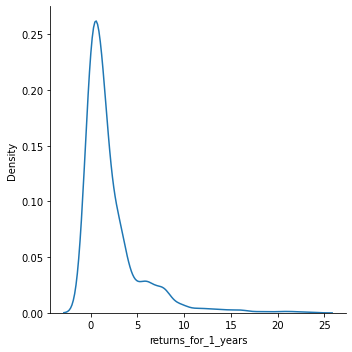

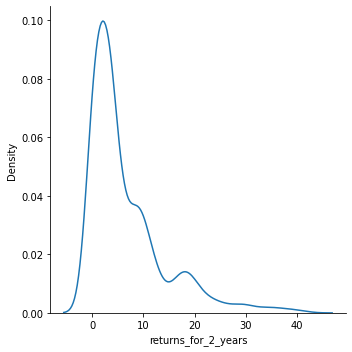

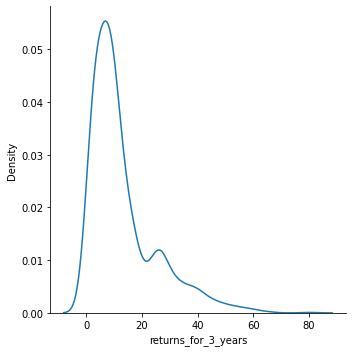

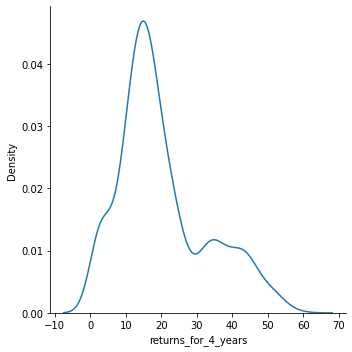

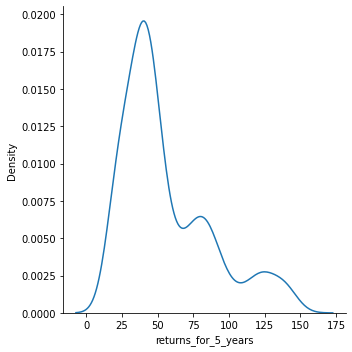

In [ ]:
for window_years in window_years_to_use:
  sns.displot(price_history_df[f"returns_for_{window_years}_years"], kind="kde")


## Distributions of annualized returns

In [ ]:
for window_years in window_years_to_use:
  print(price_history_df[f"annualized_returns_for_{window_years}_years"].describe())

count    2394.000000
mean        2.163473
std         3.208595
min        -0.832966
25%         0.282227
50%         1.160037
75%         2.831518
max        23.804691
Name: annualized_returns_for_1_years, dtype: float64
count    2029.000000
mean        1.475877
std         1.220164
min        -0.410144
25%         0.520908
50%         1.133617
75%         2.206043
max         5.554114
Name: annualized_returns_for_2_years, dtype: float64
count    1664.000000
mean        1.246837
std         0.622499
min        -0.000976
25%         0.801261
50%         1.145130
75%         1.598537
max         3.330986
Name: annualized_returns_for_3_years, dtype: float64
count    1299.000000
mean        1.072835
std         0.331325
min         0.246934
25%         0.910064
50%         1.050580
75%         1.268021
max         1.786586
Name: annualized_returns_for_4_years, dtype: float64
count    934.000000
mean       1.194712
std        0.230687
min        0.779224
25%        1.034471
50%        1.146

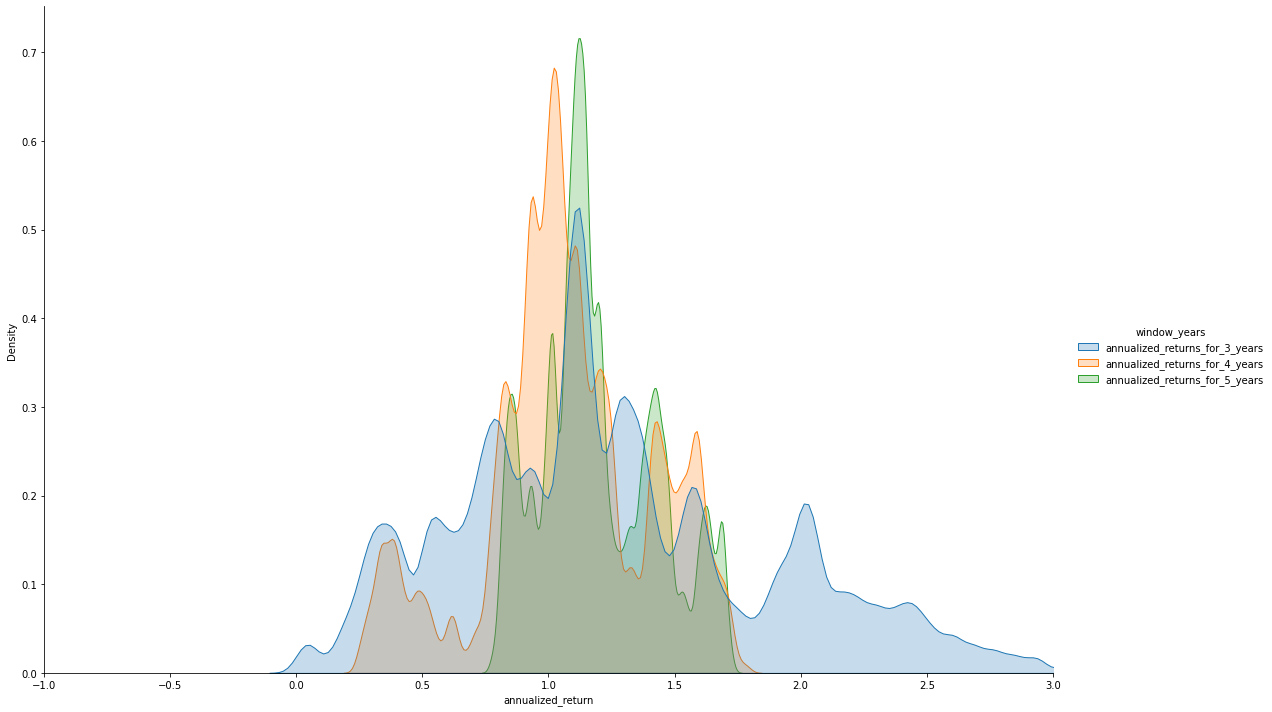

In [ ]:
annualized_return_col_names = [f"annualized_returns_for_{window_years}_years" for window_years in window_years_to_use[2:6]]
df_for_annualized_dists_plot = price_history_df.melt(id_vars=["Date"], value_vars=annualized_return_col_names, var_name="window_years", value_name="annualized_return")

the_plot = sns.displot(data=df_for_annualized_dists_plot, x="annualized_return", hue="window_years", kind='kde', fill=True, height=10,bw_adjust=0.25, aspect=1.5)
the_plot.set(xlim=(-1, 3))
the_plot

## Distribution of monthly deltas

In [ ]:
price_history_df["returns_for_1_month"].describe()

count   2729.000
mean       0.082
std        0.260
min       -0.598
25%       -0.086
50%        0.042
75%        0.212
max        1.947
Name: returns_for_1_month, dtype: float64

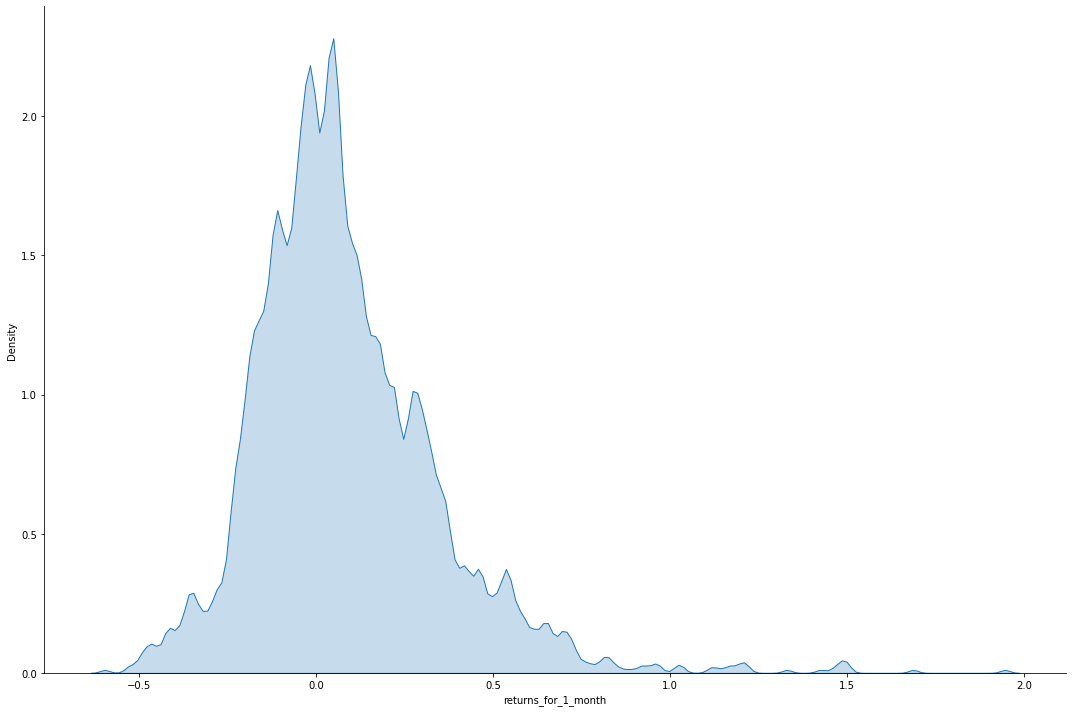

In [ ]:
# Across all history

the_plot = sns.displot(
    data=price_history_df, 
    x="returns_for_1_month", 
    kind='kde', 
    fill=True, 
    height=10,
    bw_adjust=0.25, 
    aspect=1.5
    )
the_plot

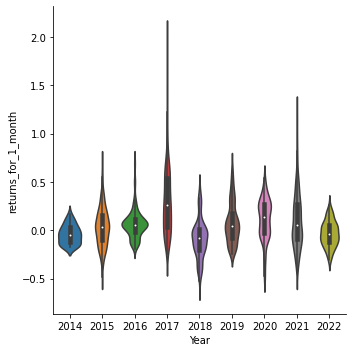

In [ ]:
# Has it changed significantly over the years?

the_plot = sns.catplot(
    data=price_history_df, 
    y="returns_for_1_month",
    x="Year",
    kind="violin"
    )
the_plot

# Simulation Analysis

Factors that come into play:
- Loan specifics
- Evolution of BTC
- Friction in EUR/BTC change
- Additional available liquidity

Metrics to observe:
- Probability 

Questions to answer:
- What is the probability that this loan can pay for itself without additional liquidity?
- What is the expected result of the operation?

## General objects

In [ ]:
class Currency:

  def __init__(self, short_name: str , long_name: str):
    self.short_name = short_name
    self.long_name = long_name

EUR = Currency("EUR", "euro")
BTC = Currency("BTC", "bitcoin")

class MoneyAmount(float):

  def __new__(cls, amount, currency):
        return super(MoneyAmount, cls).__new__(cls, amount)

  def __init__(self, amount: float, currency: Currency):
    self.amount = amount
    self.currency = currency

## Loan objects

In [ ]:
class LoanTemplate:

  def __init__(
      self,
      principal: MoneyAmount, 
      interest_rate: float, 
      length_in_months: int
      ):
    
    self.principal = principal
    self.interest_rate = interest_rate
    self.length_in_months = length_in_months

  def get_amortization_table(self):
    table_input = {
        "period": [],
        "interest_payed": [],
        "principal_payed": [],
        "amortization_amount": [],
        "remaining_balance_on_period_start": [],
        "remaining_balance_on_period_end": [],
    }

    period = 0
    balance = self.principal
    while period < self.length_in_months:
        table_input["period"].append(period)
        table_input["remaining_balance_on_period_start"].append(balance)
        interest_in_this_period = balance * self.interest_rate
        table_input["interest_payed"].append(interest_in_this_period)
        principal_in_this_period = self.amortization_amount - interest_in_this_period
        table_input["principal_payed"].append(principal_in_this_period)
        balance = balance - principal_in_this_period
        table_input["amortization_amount"] = interest_in_this_period + principal_in_this_period
        table_input["remaining_balance_on_period_end"].append(balance)
        period += 1

    return pd.DataFrame(table_input)

  @staticmethod
  def compute_loan_amortization_amount(
      principal: MoneyAmount, 
      interest_rate: float,
      number_of_periods: int
      ) -> MoneyAmount:

      return (
          principal * 
          (interest_rate * ((1 + interest_rate) ** number_of_periods)) /
          (((1 + interest_rate) ** number_of_periods) - 1)
      ) 

  @property
  def amortization_amount(self):
    return self.compute_loan_amortization_amount(
        principal = self.principal,
        interest_rate = self.interest_rate,
        number_of_periods = self.length_in_months
    )


## Swap Objects

In [ ]:
class ExchangeRateProvider:

  def __init__(self, simulated_prices: pd.DataFrame):
    self.simulated_prices = simulated_prices

  def get_exchange_rate(
      self,
      period: int, 
      from_currency: Currency, 
      to_currency: Currency
      ) -> float:
    eur_per_btc_at_period = self.simulated_prices.loc[
      self.simulated_prices["period"] == period,
      "price"
    ].values[0]

    if from_currency == EUR and to_currency == BTC:
      return 1/eur_per_btc_at_period
    if from_currency == BTC and to_currency == EUR:
      return eur_per_btc_at_period

class Swap:

  def __init__(self, input: MoneyAmount, output: MoneyAmount):
    self.input = input
    self.output = output


class Swapper:

  def input_defined_swap(
      self,
      input_amount: MoneyAmount,
      exchange_rate: float,
      output_currency: Currency
  ) -> Swap:

    output_amount = MoneyAmount(
        input_amount * exchange_rate,
        output_currency
    )

    return Swap(
        input_amount, 
        output_amount
        )

  def output_defined_swap(
      self,
      input_currency: Currency,
      exchange_rate: float,
      output_amount: MoneyAmount
  ) -> Swap:
    input_amount = MoneyAmount(
        output_amount * exchange_rate,
        input_currency
    )

    return Swap(
        input_amount,
        output_amount
    )





## Price Simulation

In [ ]:
class PriceSimulation:

  def __init__(
      self, 
      length_in_periods: int, 
      starting_price: MoneyAmount, 
      delta_generator: Callable,
      scenario_tag: str = None
      ):
    
    self.scenario_tag = scenario_tag

    self.starting_price = starting_price
    self.periods = range(0, length_in_periods)
    self.simulated_deltas = [delta_generator() for i in range(1, length_in_periods)]
    
    self.simulated_prices = [starting_price]
    for delta in self.simulated_deltas:
      next_price = self.simulated_prices[-1] * (1 + delta)
      self.simulated_prices.append(next_price)

  @property
  def price_simulation_result(self):
    return pd.DataFrame(
        {"period": self.periods,
         "price": self.simulated_prices
        }
    )

    

## Balances 



In [ ]:
class Balances:

  def __init__(
      self,
      starting_eur_balance: MoneyAmount = 0, 
      starting_btc_balance: MoneyAmount = 0
      ):
      
    self.balances = {
        EUR: starting_eur_balance,
        BTC: starting_btc_balance
    }
    self.total_payed_to_bank = 0
    self.total_emergency_line_contribution = 0

  def update_with_swap(self, swap: Swap) -> None:
    self.balances[swap.input.currency] -= swap.input
    self.balances[swap.output.currency] += swap.output

  def pay_bank(self, amount: MoneyAmount) -> None:
    self.balances[EUR] -= amount
    self.total_payed_to_bank += amount

  def bite_emergency_line(self, amount: MoneyAmount) -> None:
    self.balances[EUR] += amount
    self.total_emergency_line_contribution += amount

class BalanceHistory:
  def __init__(self):
    self.period = []
    self.eur_balance = []
    self.btc_balance = []
    self.eur_networth = []
    self.total_payed_to_bank = []
    self.total_emergency_line_contribution = []
  
  def snapshot(self, period, balances, exchange_rate_to_eur):

    self.period.append(period)
    self.eur_balance.append(balances.balances[EUR])
    self.btc_balance.append(balances.balances[BTC])
    self.eur_networth.append(
        balances.balances[EUR] +
        balances.balances[BTC] * exchange_rate_to_eur
    )
    self.total_payed_to_bank.append(
        balances.total_payed_to_bank
    )
    self.total_emergency_line_contribution.append(
        balances.total_emergency_line_contribution
    )


  @property
  def as_df(self):
    return pd.DataFrame(
        {
            "period": self.period,
            "eur_balance": self.eur_balance,
            "btc_balance": self.btc_balance,
            "eur_networth": self.eur_networth,
            "total_payed_to_bank": self.total_payed_to_bank,
            "total_emergency_line_contribution": self.total_emergency_line_contribution
        }
    )

## Full Operation Simulation

In [ ]:
def run_full_simulation(
    loan_template: LoanTemplate,
    simulated_prices: pd.DataFrame
):
  swapper = Swapper()
  exchange_rate_provider=ExchangeRateProvider(simulated_prices)
  balances = Balances(starting_eur_balance=loan_template.principal)
  balance_history = BalanceHistory()

  for period_index in range(0, loan_template.length_in_months):
    balance_history.snapshot(
        period=period_index,
        balances=balances,
        exchange_rate_to_eur=exchange_rate_provider.get_exchange_rate(
              period=period_index,
              from_currency=BTC,
              to_currency=EUR
              )
    )

    if period_index == 0:
      # Buy BTC in first period
      swap = swapper.input_defined_swap(
          input_amount=MoneyAmount(
              loan_template.principal-loan_template.amortization_amount,
              EUR),
          exchange_rate=exchange_rate_provider.get_exchange_rate(
              period=period_index,
              from_currency=EUR,
              to_currency=BTC
              ),
          output_currency=BTC
      )
      balances.update_with_swap(swap)

    if balances.balances[EUR] <= loan_template.amortization_amount:

      
      # Change to EUR if we are running out of cash to pay back loan
      swap = swapper.output_defined_swap(
          input_currency=BTC,
          exchange_rate=exchange_rate_provider.get_exchange_rate(
              period=period_index,
              from_currency=EUR,
              to_currency=BTC
              ),
          output_amount=MoneyAmount(
              loan_template.amortization_amount,
              EUR
          )
      )
      if swap.input < balances.balances[BTC]:
        # We still have enough BTC stash
        balances.update_with_swap(swap)
      else:
        # We fucked and must get liquidity from emergency line
        balances.bite_emergency_line(loan_template.amortization_amount)
    
    balances.pay_bank(
          amount=MoneyAmount(
              loan_template.amortization_amount,
              EUR
          )
      )

  return balance_history.as_df



principal_options = [20_000, 30_000, 40_000]
interest_rate_options = [0.04, 0.05, 0.06,]
length_in_months_options = [84, 106, 120]

all_options = [
               principal_options, 
               interest_rate_options, 
               length_in_months_options
               ]
all_combinations = list(itertools.product(*all_options))

possible_loans = [
  LoanTemplate(
      principal=a_principal,
      interest_rate=an_interest_rate / 12, # To monthly
      length_in_months=a_length
  )
  for a_principal, an_interest_rate, a_length
  in all_combinations
]

operation_duration_in_months=120
starting_btc_price_in_eur=40_000
n_simulations = 100

historical_price_simulations = [PriceSimulation(
    length_in_periods=operation_duration_in_months, 
    starting_price=starting_btc_price_in_eur,
    delta_generator= lambda: price_history_df["returns_for_1_month"].quantile(np.random.uniform(0,1)),
    scenario_tag="Historical"
)
for i in range(0,n_simulations)
] 
softer_1_price_simulations = [PriceSimulation(
    length_in_periods=operation_duration_in_months, 
    starting_price=starting_btc_price_in_eur,
    delta_generator= lambda: np.random.normal(0.082/2, 0.260/2),
    scenario_tag="softer_1"
)
for i in range(0,n_simulations)
]
softer_2_price_simulations = [PriceSimulation(
    length_in_periods=operation_duration_in_months, 
    starting_price=starting_btc_price_in_eur,
    delta_generator= lambda: np.random.normal(0.082/8, 0.260/8),
    scenario_tag="softer_2"
)
for i in range(0,n_simulations)
]
black_swan_price_simulations = [PriceSimulation(
    length_in_periods=operation_duration_in_months, 
    starting_price=starting_btc_price_in_eur,
    delta_generator= lambda: np.random.normal(-0.02, 0.260),
    scenario_tag="black_swan"
)
for i in range(0,n_simulations)
]

many_price_simulations = historical_price_simulations + softer_1_price_simulations + softer_2_price_simulations + black_swan_price_simulations


def sweep_options(
    possible_loans: List[LoanTemplate],
    price_simulations: List[pd.DataFrame]
) -> pd.DataFrame:

  all_options_results = {
      "loan_principal": [],
      "loan_interest_rate": [],
      "loan_length_in_months": [],
      "amortization_amount": [],
      "price_scenario": [],
      "final_btc_balance": [],
      "final_networth": [],
      "total_payed_to_bank": [],
      "total_emergency_line_contribution":[],
      "mean_monthly_emergency_line_contribution": []
  }

  for a_loan in tqdm(possible_loans):
    for a_simulation in price_simulations:
      detailed_results = run_full_simulation(
          a_loan,
          a_simulation.price_simulation_result
          )
      last_period_index = detailed_results["period"] == detailed_results["period"].max()
      final_btc_balance = detailed_results.loc[last_period_index, "btc_balance"].values[0]
      final_networth = detailed_results.loc[last_period_index,"eur_networth"].values[0]
      total_payed_to_bank = detailed_results.loc[last_period_index, "total_payed_to_bank"].values[0]
      total_emergency_line_contribution = detailed_results.loc[last_period_index, "total_emergency_line_contribution"].values[0]

      all_options_results["loan_principal"].append(a_loan.principal)
      all_options_results["loan_interest_rate"].append(a_loan.interest_rate)
      all_options_results["loan_length_in_months"].append(a_loan.length_in_months)
      all_options_results["amortization_amount"].append(a_loan.amortization_amount)
      all_options_results["price_scenario"].append(a_simulation.scenario_tag)
      all_options_results["final_btc_balance"].append(final_btc_balance)
      all_options_results["final_networth"].append(final_networth - total_emergency_line_contribution)
      all_options_results["total_payed_to_bank"].append(total_payed_to_bank)
      all_options_results["total_emergency_line_contribution"].append(total_emergency_line_contribution)
      all_options_results["mean_monthly_emergency_line_contribution"].append(total_emergency_line_contribution / a_loan.length_in_months)

  
  return pd.DataFrame(all_options_results)


all_options_results = sweep_options(possible_loans, many_price_simulations)

100%|██████████| 27/27 [12:02<00:00, 26.76s/it]


In [ ]:
all_options_results.to_excel("final_loan_check.xlsx")
files.download("final_loan_check.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>